# IMPORTS

In [1]:
import numpy as np
import pydensecrf.densecrf as dcrf
from PIL import Image
import tensorflow as tf
import skimage.io as io
import pickle
import os
from matplotlib import pyplot as plt
from pydensecrf.utils import compute_unary, create_pairwise_bilateral, \
    create_pairwise_gaussian, unary_from_softmax

In [2]:
img_name = 'SEM_data15'
path_testing = '../data/baseline_testing/' + img_name
model_name='baseline_classic'
path_saving='../../../axondeepseg-atrous/axondeepseg/models/'+model_name

In [3]:
final_probabilities=pickle.load( open( os.path.join(path_saving,img_name + '_pred_proba.pkl'), "rb" ) )

In [4]:
final_probabilities['proba']

array([[[0.43217116, 0.34965854, 0.2181703 ],
        [0.35156131, 0.57109173, 0.07734696],
        [0.3392314 , 0.60243531, 0.05833328],
        ...,
        [0.33858356, 0.52417135, 0.13724509],
        [0.38941188, 0.39724617, 0.21334195],
        [0.41138441, 0.17457373, 0.41404185]],

       [[0.32807064, 0.58129257, 0.0906368 ],
        [0.29217601, 0.67486447, 0.03295952],
        [0.29898217, 0.67888408, 0.02213375],
        ...,
        [0.33788686, 0.57062891, 0.09148423],
        [0.35447566, 0.51388598, 0.13163836],
        [0.40555955, 0.30653883, 0.28790162]],

       [[0.30511632, 0.62745793, 0.06742574],
        [0.28877652, 0.68898176, 0.02224172],
        [0.30477609, 0.68046867, 0.01475524],
        ...,
        [0.36825537, 0.54427493, 0.08746969],
        [0.37781563, 0.4890607 , 0.13312367],
        [0.43199029, 0.30017603, 0.26783368]],

       ...,

       [[0.17981613, 0.7687426 , 0.05144127],
        [0.09303299, 0.89277248, 0.01419453],
        [0.05283075, 0

In [5]:
softmax = np.ones((1,final_probabilities['proba'].shape[0],final_probabilities['proba'].shape[1],final_probabilities['proba'].shape[2]))
softmax[0,:,:,:]=final_probabilities['proba']

In [6]:
image = plt.imread(os.path.join(path_testing,'image.png'))

final_probabilities=np.expand_dims(final_probabilities['proba'].shape,axis=0)

Now we adapt the code from tf deeplab resnet

In [7]:


n_classes = 3
# colour map
label_colours = [0,  # 0= background
                128, # 1= myelin
                255] # 2= axon
                   
def decode_labels(mask, num_images=1):
    """Decode batch of segmentation masks.
    
    Args:
      mask: result of inference after taking argmax.
      num_images: number of images to decode from the batch.
    
    Returns:
      A batch with num_images RGB images of the same size as the input. 
    """
    n, h, w, c = mask.shape
    assert(n >= num_images), 'Batch size %d should be greater or equal than number of images to save %d.' % (n, num_images)
    outputs = np.zeros((num_images, h, w, 3), dtype=np.uint8)
    for i in range(num_images):
        img = Image.new('RGB', (len(mask[i, 0]), len(mask[i])))
        pixels = img.load()
        for j_, j in enumerate(mask[i, :, :, 0]):
            for k_, k in enumerate(j):
                if k < n_classes:
                    pixels[k_,j_] = label_colours[k]
        outputs[i] = np.array(img)
    return outputs

def prepare_label(input_batch, new_size):
    """Resize masks and perform one-hot encoding.
    Args:
      input_batch: input tensor of shape [batch_size H W 1].
      new_size: a tensor with new height and width.
    Returns:
      Outputs a tensor of shape [batch_size h w 21]
      with last dimension comprised of 0's and 1's only.
    """
    with tf.name_scope('label_encode'):
        input_batch = tf.image.resize_nearest_neighbor(input_batch, new_size) # as labels are integer numbers, need to use NN interp.
        input_batch = tf.squeeze(input_batch, squeeze_dims=[3]) # reducing the channel dimension.
        input_batch = tf.one_hot(input_batch, depth=n_classes)
    return input_batch

def inv_preprocess(imgs, num_images=1):
    """Inverse preprocessing of the batch of images.
     Add the mean vector and convert from BGR to RGB.

    Args:
    imgs: batch of input images.
    num_images: number of images to apply the inverse transformations on.

    Returns:
    The batch of the size num_images with the same spatial dimensions as the input.
    """
    n, h, w, c = imgs.shape
    assert(n >= num_images), 'Batch size %d should be greater or equal than number of images to save %d.' % (n, num_images)
    outputs = np.zeros((num_images, h, w, c), dtype=np.uint8)
    for i in range(num_images):
        outputs[i] = (imgs[i] + IMG_MEAN)[:, :, ::-1].astype(np.uint8)
    return outputs

def dense_crf(probs, img=None, n_iters=10, 
              sxy_gaussian=(1, 1), compat_gaussian=4,
              kernel_gaussian=dcrf.DIAG_KERNEL,
              normalisation_gaussian=dcrf.NORMALIZE_SYMMETRIC,
              sxy_bilateral=(49, 49),
              schan_bilateral=(1,)):
    """DenseCRF over unnormalised predictions.
       More details on the arguments at https://github.com/lucasb-eyer/pydensecrf.
    
    Args:
      probs: class probabilities per pixel.
      img: if given, the pairwise bilateral potential on raw RGB values will be computed.
      n_iters: number of iterations of MAP inference.
      sxy_gaussian: standard deviations for the location component of the colour-independent term.
      compat_gaussian: label compatibilities for the colour-independent term (can be a number, a 1D array, or a 2D array).
      kernel_gaussian: kernel precision matrix for the colour-independent term (can take values CONST_KERNEL, DIAG_KERNEL, or FULL_KERNEL).
      normalisation_gaussian: normalisation for the colour-independent term (possible values are NO_NORMALIZATION, NORMALIZE_BEFORE, NORMALIZE_AFTER, NORMALIZE_SYMMETRIC).
      sxy_bilateral: standard deviations for the location component of the colour-dependent term.
      compat_bilateral: label compatibilities for the colour-dependent term (can be a number, a 1D array, or a 2D array).
      srgb_bilateral: standard deviations for the colour component of the colour-dependent term.
      kernel_bilateral: kernel precision matrix for the colour-dependent term (can take values CONST_KERNEL, DIAG_KERNEL, or FULL_KERNEL).
      normalisation_bilateral: normalisation for the colour-dependent term (possible values are NO_NORMALIZATION, NORMALIZE_BEFORE, NORMALIZE_AFTER, NORMALIZE_SYMMETRIC).
      
    Returns:
      Refined predictions after MAP inference.
    """
    _, h, w, _ = probs.shape
    
    probs = probs[0].transpose(2, 0, 1).copy(order='C') # Need a contiguous array.
    
    d = dcrf.DenseCRF2D(w, h, n_classes) # Define DenseCRF model.
    U = -np.log(probs) # Unary potential.
    U = U.reshape((n_classes, -1)) # Needs to be flat.
    d.setUnaryEnergy(U)
    d.addPairwiseGaussian(sxy=sxy_gaussian, compat=compat_gaussian,
                          kernel=kernel_gaussian, normalization=normalisation_gaussian)
    if img is not None:
        assert(img.shape[0:2] == (h, w)), "The image height and width must coincide with dimensions of the logits."
        pairwise_energy = create_pairwise_bilateral(sdims=sxy_bilateral, schan=schan_bilateral, img=img, chdim=-1)
        d.addPairwiseEnergy(pairwise_energy, compat=10)

    Q = d.inference(n_iters)
    preds = np.array(Q, dtype=np.float32).reshape((n_classes, h, w)).transpose(1, 2, 0)
    return np.expand_dims(preds, 0)


# INFERENCE

In [8]:
#output_crf = tf.py_func(dense_crf, softmax, tf.float32)
softmax = softmax.astype(np.float32)
output_crf = dense_crf(softmax,img=image,
                       sxy_gaussian=(57,57),
                       sxy_bilateral=(0.82,0.82),
                       schan_bilateral=(17))
#output_crf = tf.argmax(output_crf, dimension=3)

In [9]:
pred = tf.expand_dims(output_crf, dim=3)
sess=tf.Session()
with sess :
    out_pred = pred.eval()
out_pred=np.squeeze(out_pred) 

In [10]:
out_pred

array([[[3.95250172e-05, 9.99927282e-01, 3.31390693e-05],
        [1.37607012e-05, 9.99981284e-01, 5.05532216e-06],
        [1.63267596e-05, 9.99978900e-01, 4.71300655e-06],
        ...,
        [4.30363543e-05, 9.99946117e-01, 1.08375179e-05],
        [5.56868217e-05, 9.99925375e-01, 1.89865332e-05],
        [1.89599377e-04, 9.99691486e-01, 1.18939985e-04]],

       [[1.71657994e-05, 9.99974966e-01, 7.90956528e-06],
        [5.04273248e-06, 9.99994040e-01, 9.53850531e-07],
        [7.13422969e-06, 9.99992013e-01, 8.90292029e-07],
        ...,
        [2.22132003e-05, 9.99974132e-01, 3.73520993e-06],
        [1.88885897e-05, 9.99976754e-01, 4.36471191e-06],
        [1.10233996e-04, 9.99840975e-01, 4.87817779e-05]],

       [[1.75096739e-05, 9.99976039e-01, 6.48037212e-06],
        [5.15993588e-06, 9.99994159e-01, 6.69148676e-07],
        [8.82016775e-06, 9.99990463e-01, 7.22766515e-07],
        ...,
        [2.35188272e-05, 9.99973059e-01, 3.46813044e-06],
        [1.67418002e-05, 9.99

In [12]:
path_saving=os.path.join('../../../axondeepseg-atrous/axondeepseg/models/',model_name)

save_dict_proba={'proba':out_pred}
with open(os.path.join(path_saving, img_name+'_pred_proba_crf.pkl'), 'w') as handle:
    pickle.dump(save_dict_proba, handle, protocol=pickle.HIGHEST_PROTOCOL)

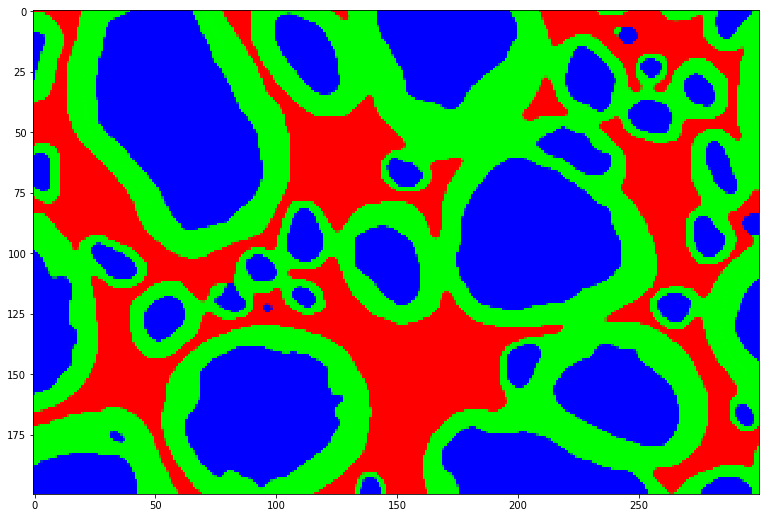

In [13]:
plt.figure(figsize=(13,10))
#plt.subplot(2,1,1)
plt.imshow(out_pred[100:300,700:1000])
#plt.subplot(2,1,2)
#plt.imshow(out_pred_save[100:300,700:1000])

In [10]:
plt.imsave('post_crf.png',out_pred)

In [11]:
out_pred_save=out_pred

In [12]:
from scipy.misc import imread, imsave
from AxonDeepSeg.testing.segmentation_scoring import *


In [13]:
mask = imread('../data/baseline_testing/SEM_data15/mask.png', flatten=True)

/home/mawab_local/.virtualenvs/aspp/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [14]:
gt_axon = 1.0*(mask > 200)
gt_myelin = 1.0*np.logical_and(mask >= 50, mask <= 200)
gt_bg = 1.0*(mask < 50)

per_axon=np.sum(gt_axon)/(np.shape(gt_axon)[0]*np.shape(gt_axon)[1])
per_myelin=np.sum(gt_myelin)/(np.shape(gt_axon)[0]*np.shape(gt_axon)[1])
per_bg=np.sum(gt_bg)/(np.shape(gt_axon)[0]*np.shape(gt_axon)[1])

pred_axon = 1.0*(out_pred == 2)
pred_myelin = 1.0*(out_pred == 1)
pred_bg = 1.0*(out_pred == 0)

dice_axon = pw_dice(pred_axon, gt_axon)
dice_myelin = pw_dice(pred_myelin, gt_myelin)
dice_bg = pw_dice(pred_bg, gt_bg)
total_dice = per_bg*dice_bg + per_myelin*dice_myelin + per_axon*dice_axon

print 'Dice for Axon : ' + str(dice_axon)
print 'Dice for myelin : ' + str(dice_myelin)
print 'Dice for Background : ' + str(dice_bg)
print 'Total dice : ' + str(total_dice)

Dice for Axon : 0.9039041977753345
Dice for myelin : 0.8200798342838528
Dice for Background : 0.8061852471790136
Total dice : 0.8400004650015951


In [15]:
from sklearn.metrics import accuracy_score

In [16]:
gt_discretized=np.zeros_like(gt_bg)+gt_myelin+2*gt_axon


In [17]:
total_accuracy=accuracy_score(gt_discretized.ravel(),out_pred.ravel())

In [18]:
total_accuracy

0.8410344570544716

# OPTIMISATION DES HP DU CRF

In [19]:
vec_xy=np.linspace(15,40,26)
vec_res=[]

for i,sxy in enumerate(vec_xy):
    print 'Iter ', i
    # Prediction
    output_crf = dense_crf(softmax,img=image,
                           sxy_gaussian=(57,57),
                           sxy_bilateral=(0.82,0.82),
                           schan_bilateral=(sxy))
    output_crf = tf.argmax(output_crf, dimension=3)
    
    # Evaluation of the results
    pred = tf.expand_dims(output_crf, dim=3)
    sess=tf.Session()
    with sess :
        out_pred = pred.eval()
    out_pred=np.squeeze(out_pred) 
    
    pred_axon = 1.0*(out_pred == 2)
    pred_myelin = 1.0*(out_pred == 1)
    pred_bg = 1.0*(out_pred == 0)

    dice_axon = pw_dice(pred_axon, gt_axon)
    dice_myelin = pw_dice(pred_myelin, gt_myelin)
    dice_bg = pw_dice(pred_bg, gt_bg)
    total_dice = per_bg*dice_bg + per_myelin*dice_myelin + per_axon*dice_axon
    vec_res.append(total_dice)
    
    

Iter  0
Iter  1


KeyboardInterrupt: 

In [ ]:
sess.close()

In [ ]:
plt.figure()
plt.plot(vec_res)
plt.show()